In [1]:
import os
os.chdir('..')
import torch
import gc
import numpy as np
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow,imsShow
import matplotlib.pyplot as plt
from model.seg_model.model_scales_gate import unet_scales_gate
from swatnet_infer import swatnet_infer
from utils.get_s1pair_nor import get_s1pair_nor


In [2]:
# ----------- Device --------------- #
# device = torch.device('cuda:0')
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [9]:
import glob
path_s1as = 'data/tibet_tiles/s1_ascend'
path_s1des = 'data/tibet_tiles/s1_descend'
ifile_as = glob.glob(path_s1as + '/*')
ifile_des = glob.glob(path_s1des + '/*')

### obtain pair-wise ascending/descending files.
io_files = []
dir_wat = '/'.join(ifile_as[0].split('/')[:-2]) + '/s1_water'

for i_as in ifile_as:
    for i_des in ifile_des:
        if i_as.split('/')[-1].split('_')[-1] == i_des.split('/')[-1].split('_')[-1]:
            if not os.path.exists(dir_wat):
                os.makedirs(dir_wat)
            name_wat = i_as.split('/')[-1].split('.')[0] + '_water.tif'
            name_wat = name_wat.replace('s1as', 's1')
            o_water = dir_wat + '/' + name_wat
            io_files.append((i_as, i_des, o_water))   
        else:
            continue

io_files = sorted(io_files)
print(io_files[0])


('data/tibet_tiles/s1_ascend/tibet_s1as_202008_tile_1.tif', 'data/tibet_tiles/s1_descend/tibet_s1des_202008_tile_1.tif', 'data/tibet_tiles/s1_water/tibet_s1_202008_tile_1_water.tif')


In [ ]:
'''Model loading'''
model_name= 'model_scales_gate'
path_model_weights = 'model/pretrained/'+ model_name +'_weights.pth'
# model = unet_scales(num_bands=4, num_classes=2, \
#                         scale_high=2048, scale_mid=512, scale_low=256)
model = unet_scales_gate(num_bands=4, num_classes=2, \
                        scale_high=2048, scale_mid=512, scale_low=256)
if torch.cuda.is_available():
    model.load_state_dict(torch.load(path_model_weights,map_location='cuda:0'))
else:
    model.load_state_dict(torch.load(path_model_weights,map_location='cpu'))
model.to(device)        # load on gpu
model = model.eval()
type(model)


In [ ]:
for i in range(len(io_files)):

    ### ---- 1. preprocessing
    ### ---- 1.1 data reading
    print('--- data reading...')
    print(io_files[i][0])
    print(io_files[i][1])
    s1_ascend, s1_ascend_info = readTiff(path_in = io_files[i][0])
    s1_descend, _ = readTiff(path_in = io_files[i][1])

    ### --- 1.2 get normalized s1_image
    s1_img_nor = get_s1pair_nor(s1_as=s1_ascend, s1_des=s1_descend)
    print('image shape:', s1_img_nor.shape)
    del s1_ascend, s1_descend
    gc.collect()

    ### ---- 2. surface water mapping ----
    print('--- surface water mapping using swatnet model...')
    wat_map = swatnet_infer(s1_img=s1_img_nor, model=model)
    del s1_img_nor
    gc.collect()

    ### ---- 3. write out the water map -----
    print('--- write out the result image...')
    writeTiff(im_data = wat_map.astype(np.int8), 
                im_geotrans = s1_ascend_info['geotrans'], 
                im_geosrs = s1_ascend_info['geosrs'], 
                path_out = io_files[i][2])
    print('--- write out -->')
    print(io_files[i][2])
    del wat_map
    gc.collect()


### Visualize the final classification map

(93.52243641981403, 94.73552137948903, 25.9051670057967, 26.98152837922871)

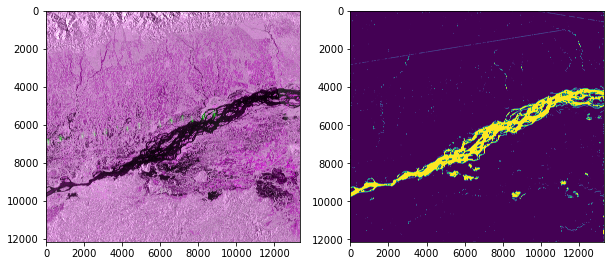

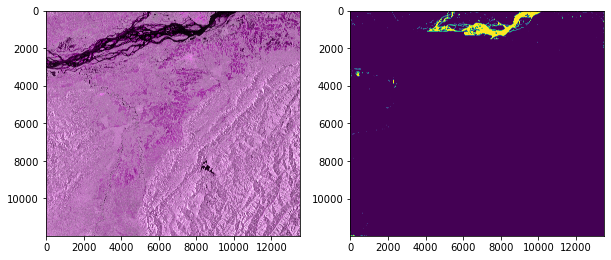

In [19]:
for i in range(len(io_files)):
    ### ---- 1. data reading
    s1_ascend, s1_info = readTiff(path_in = io_files[i][0])
    s1_water, _ = readTiff(path_in = io_files[i][2])
    ### ---- 2. show the image and result
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    imgShow(s1_ascend, clip_percent=2, color_bands=(0,1,0))
    plt.subplot(1,2,2)
    imgShow(s1_water)


In [18]:
s1_water_tile_1, _ = readTiff(path_in = io_files[0][2])
s1_water_tile_3, _ = readTiff(path_in = io_files[1][2])

